In [14]:
#importing required modules

from pathlib import Path
from tempfile import NamedTemporaryFile
import fileinput
import os
import rdkit
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import gensim
import matplotlib.pyplot as plt
import gensim.downloader
from rdkit.Chem import Descriptors
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, LeaveOneOut, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel as C, RationalQuadratic, Matern
from sklearn.model_selection import KFold
import numpy as np
import itertools
import random
import scipy



In [15]:
'''
Three functions that assist in converting lists to strings and vice versa.
These are helpful when storing vectors in csv files. 
'''

def str2float(string):
    split = list(string.split(','))
    floats_split = []
    for i in range(len(split)):
        floats = float(split[i])
        floats_split.append(floats)
    return floats_split

def stringToList(vectors):
    bracket_removed_mol2vec = []
    for i in range(len(vectors)):
        new_strings = vectors[i].replace('[', '')
        newer_strings = new_strings.replace(']', '')
        bracket_removed_mol2vec.append(newer_strings)

# Convert all vectors
    xList = []
    for i in range(len(bracket_removed_mol2vec)):
        float_vec = str2float(bracket_removed_mol2vec[i])
        xList.append(float_vec)
    
    return xList

def listToString(vectors):
    string_indices = []
    for i in range(len(vectors)):
        knn_string = ', '.join(str(k) for k in vectors[i])
        string_indices.append(knn_string)

    bracket_string_indices = []
    for i in range(len(string_indices)):
        bracket_string = '[' + string_indices[i] + ']'
        bracket_string_indices.append(bracket_string)
    
    return bracket_string_indices

In [16]:
def get_bootstrap_samples(data, n_samples, replace: bool = True, s = 228, noise_scale: float = 0.5):
    """
    Wrapper function to bootstrap column densities in a dataset.
    The idea here is to generate "new" data by sampling with
    replacement, and adding Gaussian noise to the log column
    densities. The scale of the noise is set by the parameter
    `noise_scale`.
    Parameters
    ----------
    data : Tuple[np.ndarray]
        2-tuple containing X (2D) and y (1D) NumPy arrays
    s : int
        Seed used to set the random state
    n_samples : int, optional
        Target dataset size, by default 500
    replace : bool, optional
        Whether to do bootstrapping with replacement, by default True
    noise_scale : float, optional
        Gaussian scale for target noise, by default 0.5
    Returns
    -------
    2-tuple
        boot_X is a 2D NumPy array of features with
        shape [N, L] where N = `n_samples`. boot_y
        is a NumPy 1D array with bootstrapped, noisy
        regression targets with shape [N].
    """
    boot_X, boot_y = resample(*data, n_samples=n_samples, replace=replace, random_state=s)
    rng = np.random.default_rng(s)
    boot_y += rng.normal(0., noise_scale, size=boot_y.size)
    return boot_X, boot_y

In [17]:
'''
function to scale both training and validation feature vectors with Standard Scaler object
'''

def scaleDataVal(X_train,X_val):
    scaler = preprocessing.StandardScaler().fit(X_train) #creating Standard Scaler Object 
    X_train_scaled = scaler.transform(X_train) #Scaling X_train
    #X_tot_scaled = scaler.transform(X_tot)
    X_val_scaled = scaler.transform(X_val)
    return X_train_scaled, X_val_scaled

In [18]:
'''
This function splits the deuterated molecules in the dataset into five "folds" of training
and validation sets for 5-fold cross validation.

All deuterated isotopologues of the same molecule are assigned to the validation set of a 
single fold. 

The data for each fold is then appropriately bootstrapped and scaled. 

Returns:

xTrain: List of five lists. Each contains the bootstrapped and scaled feature vectors of the molecules
assigned to the training data on one fold.

yTrain: List of five lists. Each contains the bootstrapped column densities of the molecules
assigned to the training data on one fold.

xTest: List of five lists. Each contains the bootstrapped and scaled feature vectors of the molecules
assigned to the validation data on one fold.

yTest: List of five lists. Each contains the bootstrapped column densities of the molecules
assigned to the validation data on one fold.


finalSmiles: List of five lists. Each contains the SMILES strings of the molecules assigned
to the validation data on one fold

'''


def getSplitsD(n = 5, bootSize = 800):
    fullPath = os.path.join(os.getcwd(), 'dRatiosFinal.csv')
    iso = pd.read_csv(fullPath)
    smiles = list(iso['smiles'])
    parentIdx = list(iso['parent idx'])
    maxIdx = max(parentIdx) + 1
    
    listIdx = list(range(maxIdx))

    kf = KFold(n_splits=n, shuffle = True, random_state = 0)
    fullTrain = []
    fullTest = []
    for train, test in kf.split(listIdx):
        fullTrain.append(train)
        fullTest.append(test)
    
    testSmiles = []
    
    for sub in fullTest:
        subSmiles = []
        for i in range(len(parentIdx)):
            if parentIdx[i] in sub:
                subSmiles.append(smiles[i])
                    
        testSmiles.append(subSmiles)
    
    
    
    fullPath2 = os.path.join(os.getcwd(), 'final_detections.csv')
    full = pd.read_csv(fullPath2)
    
    fullSmiles = list(full['smiles'])
    vectors = stringToList(list(full['final vectors iso 70']))
    cd = np.log10(np.asarray(full['N']))
    
    
    xTrain = []
    yTrain = []
    xTest = []
    yTest = []
    
    
    finalSmiles = []
    for sub in testSmiles:
        splitSmiles = []
        sub_x_Train = []
        sub_y_Train = []
        sub_x_Test = []
        sub_y_Test = []
        for i in range(len(fullSmiles)):
            if fullSmiles[i] in sub:
                splitSmiles.append(fullSmiles[i])
                sub_x_Test.append(vectors[i])
                sub_y_Test.append(cd[i])

            else:
                sub_x_Train.append(vectors[i])
                sub_y_Train.append(cd[i])
                
        sub_x_Train = np.asarray(sub_x_Train)
        sub_y_Train = np.asarray(sub_y_Train)
        sub_x_Test = np.asarray(sub_x_Test)
        sub_y_Test = np.asarray(sub_y_Test)
        X_train_boot, y_train_boot = get_bootstrap_samples((sub_x_Train, sub_y_Train), n_samples = 800)
        X_train_scaled, X_test_scaled= scaleDataVal(X_train_boot,sub_x_Test)
        xTrain.append(X_train_scaled)
        yTrain.append(y_train_boot)
        xTest.append(X_test_scaled)
        yTest.append(sub_y_Test)
        finalSmiles.append(splitSmiles)
            
            
 
    return xTrain, yTrain, xTest, yTest, finalSmiles
   
   
    

In [19]:
import random


'''
This function splits the 13C substituted molecules in the dataset into five "folds" of training
and validation sets for 5-fold cross validation.

All deuterated isotopologues of the same molecule are assigned to the validation set of a 
single fold. 

The data for each fold is then appropriately bootstrapped and scaled. 

Returns:

xTrain: List of five lists. Each contains the bootstrapped and scaled feature vectors of the molecules
assigned to the training data on one fold.

yTrain: List of five lists. Each contains the bootstrapped column densities of the molecules
assigned to the training data on one fold.

xTest: List of five lists. Each contains the bootstrapped and scaled feature vectors of the molecules
assigned to the validation data on one fold.

yTest: List of five lists. Each contains the bootstrapped column densities of the molecules
assigned to the validation data on one fold.


finalSmiles: List of five lists. Each contains the SMILES strings of the molecules assigned
to the validation data on one fold

'''


def getSplitsC(n = 5, bootSize = 800):
    fullPath = os.path.join(os.getcwd(), 'cRatiosFinal.csv')
    iso = pd.read_csv(fullPath)
    smiles = list(iso['smiles'])
    parentIdx = list(iso['parent idx'])
    maxIdx = max(parentIdx) + 1
    
    listIdx = list(range(maxIdx))

    kf = KFold(n_splits=n, shuffle = True, random_state = 0)
    fullTrain = []
    fullTest = []
    for train, test in kf.split(listIdx):
        fullTrain.append(train)
        fullTest.append(test)

    
    testSmiles = []
    
    for sub in fullTest:
        subSmiles = []
        for i in range(len(parentIdx)):
            if parentIdx[i] in sub:
                subSmiles.append(smiles[i])
                    
        testSmiles.append(subSmiles)
    
    
    
    fullPath2 = os.path.join(os.getcwd(), 'final_detections.csv')
    full = pd.read_csv(fullPath2)
    
    fullSmiles = list(full['smiles'])
    vectors = stringToList(list(full['final vectors iso 70']))
    cd = np.log10(np.asarray(full['N']))
    
    
    xTrain = []
    yTrain = []
    xTest = []
    yTest = []
    
    
    finalSmiles = []
    for sub in testSmiles:
        splitSmiles = []
        sub_x_Train = []
        sub_y_Train = []
        sub_x_Test = []
        sub_y_Test = []
        for i in range(len(fullSmiles)):
            if fullSmiles[i] in sub:
                splitSmiles.append(fullSmiles[i])
                sub_x_Test.append(vectors[i])
                sub_y_Test.append(cd[i])

            else:
                sub_x_Train.append(vectors[i])
                sub_y_Train.append(cd[i])
                
        sub_x_Train = np.asarray(sub_x_Train)
        sub_y_Train = np.asarray(sub_y_Train)
        sub_x_Test = np.asarray(sub_x_Test)
        sub_y_Test = np.asarray(sub_y_Test)
        X_train_boot, y_train_boot = get_bootstrap_samples((sub_x_Train, sub_y_Train), n_samples = 800)
        X_train_scaled, X_test_scaled= scaleDataVal(X_train_boot,sub_x_Test)
        xTrain.append(X_train_scaled)
        yTrain.append(y_train_boot)
        xTest.append(X_test_scaled)
        yTest.append(sub_y_Test)
        finalSmiles.append(splitSmiles)
            
            
 
    return xTrain, yTrain, xTest, yTest, finalSmiles
   
    

In [20]:
'''
This code cell runs five-fold cross validation on the folds of deuterated data that is split with the 
getSplitsD() function. The prediction and reported column densities are saved to a csv file along with the predicted and reported
isotopic ratios.
'''


GPR_paramSet = (0.1, 10, 10, 0.1, 20, 3)
kernel = WhiteKernel(GPR_paramSet[3], noise_level_bounds = (1e-30, 1e30))+ RationalQuadratic(alpha = GPR_paramSet[1], length_scale = GPR_paramSet[0], length_scale_bounds = (1e-30, 1e30), alpha_bounds = (1e-30, 1e30)) + DotProduct(sigma_0=GPR_paramSet[2], sigma_0_bounds = (1e-30, 1e30)) 
model = GaussianProcessRegressor(kernel = kernel, normalize_y = True, n_restarts_optimizer = GPR_paramSet[4], alpha = GPR_paramSet[5])

fullPredictions = []
xTrain, yTrain, xTest, yTest, smilesList = getSplitsD(n = 5)
for i in range(len(xTrain)):
    X_train = xTrain[i]
    y_train = yTrain[i]
    X_test = xTest[i]
    y_test = yTest[i]
    smiles_test = smilesList[i]
    result = model.fit(X_train, y_train)
    test_pred, test_sd = result.predict(X_test, return_std = True)

    for i in range(len(test_pred)):
        fullPredictions.append((smiles_test[i],test_pred[i], test_sd[i]))

fullPath = os.path.join(os.getcwd(), 'dRatiosFinal.csv')
fullUpload = pd.read_csv(fullPath)


smiles = list(fullUpload['smiles'])
reportCD = list(fullUpload['reported CD'])
parentCD = list(fullUpload['parent CD'])

smilesPred = [i[0] for i in fullPredictions]
cd = [i[1] for i in fullPredictions]
sd = [i[2] for i in fullPredictions]


sdFinal = []
ratio = []
predFinal = []
residualList = []



for i in range(len(smiles)):
    idx = smilesPred.index(smiles[i])
    parentVal = parentCD[i]
    smile = smilesPred[idx]
    cdVal = cd[idx]
    sdVal = sd[idx]

    sdFinal.append(sdVal)
    predFinal.append(cdVal)


    reportVal = reportCD[i]

    residual = abs(cdVal - reportVal)

    residualList.append(residual)

    predValExp = 10**(cdVal)
    parentValExp = 10**(parentVal)

    ratioVal = predValExp/parentValExp

    ratio.append(ratioVal)


fullUpload['predicted ratio'] = ratio
fullUpload['predicted CD'] = predFinal
fullUpload['residual'] = residualList
fullUpload['sd'] = sdFinal

saveString = 'deuterium_results.csv'

savePath = os.path.join(os.getcwd(), saveString)
fullUpload.to_csv(savePath)

In [21]:
'''
This code cell runs five-fold cross validation on the folds of 13C substituted data that is split with the 
getSplitsC() function. The prediction and reported column densities are saved to a csv file along with the predicted and reported
isotopic ratios.
'''


GPR_paramSet = (0.1, 10, 10, 0.1, 20, 3)
kernel = WhiteKernel(GPR_paramSet[3], noise_level_bounds = (1e-30, 1e30))+ RationalQuadratic(alpha = GPR_paramSet[1], length_scale = GPR_paramSet[0], length_scale_bounds = (1e-30, 1e30), alpha_bounds = (1e-30, 1e30)) + DotProduct(sigma_0=GPR_paramSet[2], sigma_0_bounds = (1e-30, 1e30)) 
model = GaussianProcessRegressor(kernel = kernel, normalize_y = True, n_restarts_optimizer = GPR_paramSet[4], alpha = GPR_paramSet[5])

fullPredictions = []
xTrain, yTrain, xTest, yTest, smilesList = getSplitsC(n = 5)
for i in range(len(xTrain)):
    X_train = xTrain[i]
    y_train = yTrain[i]
    X_test = xTest[i]
    y_test = yTest[i]
    smiles_test = smilesList[i]
    result = model.fit(X_train, y_train)
    test_pred, test_sd = result.predict(X_test, return_std = True)

    for i in range(len(test_pred)):
        fullPredictions.append((smiles_test[i],test_pred[i], test_sd[i]))

fullPath = os.path.join(os.getcwd(), 'cRatiosFinal.csv')
fullUpload = pd.read_csv(fullPath)

del fullUpload['predicted CD']
del fullUpload['predicted ratio']
del fullUpload['residual']
del fullUpload['sd']


smiles = list(fullUpload['smiles'])
reportCD = list(fullUpload['reported CD'])
parentCD = list(fullUpload['parent CD'])

smilesPred = [i[0] for i in fullPredictions]
cd = [i[1] for i in fullPredictions]
sd = [i[2] for i in fullPredictions]


sdFinal = []
ratio = []
predFinal = []
residualList = []



for i in range(len(smiles)):
    idx = smilesPred.index(smiles[i])
    parentVal = parentCD[i]
    smile = smilesPred[idx]
    cdVal = cd[idx]
    sdVal = sd[idx]

    sdFinal.append(sdVal)
    predFinal.append(cdVal)


    reportVal = reportCD[i]

    residual = abs(cdVal - reportVal)

    residualList.append(residual)

    predValExp = 10**(cdVal)
    parentValExp = 10**(parentVal)

    ratioVal = parentValExp/predValExp

    ratio.append(ratioVal)


fullUpload['predicted ratio'] = ratio
fullUpload['predicted CD'] = predFinal
fullUpload['residual'] = residualList
fullUpload['sd'] = sdFinal

saveString = 'carbon_results.csv'

savePath = os.path.join(os.getcwd(), saveString)
fullUpload.to_csv(savePath)

<Figure size 640x480 with 0 Axes>

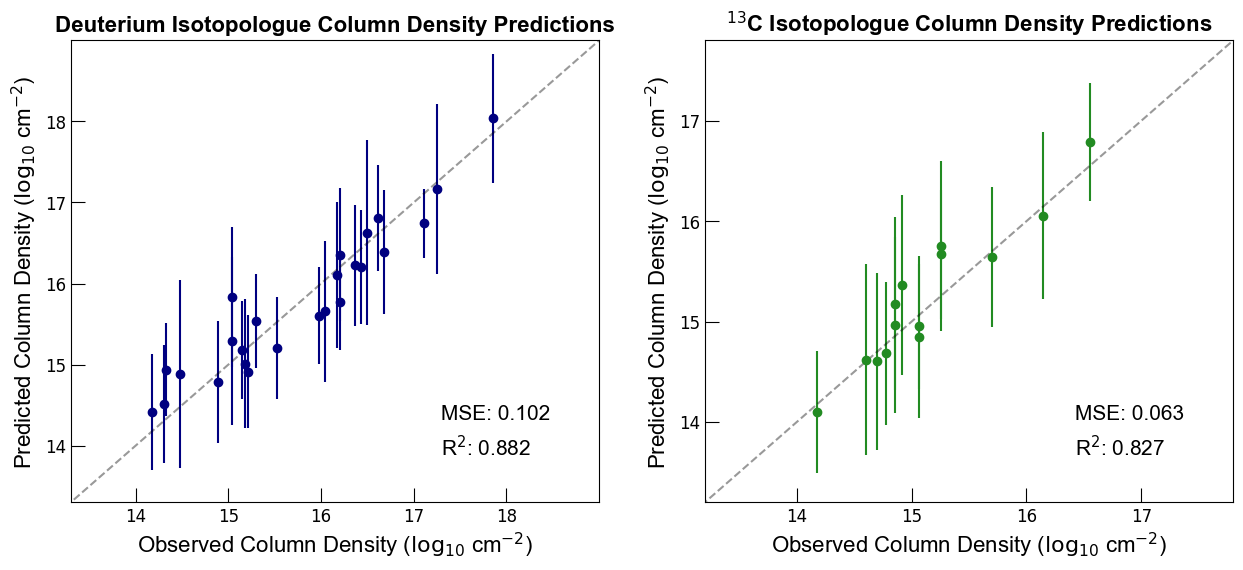

In [22]:
'''
This code cell plots the column density predictions of the D and 13C substituted molecules.
The feature vectors contain hand-picked isotope features.
'''

import scipy


hfont = {'fontname':'Arial'}
pathStringD = 'deuterium_results.csv'
fullPathD = os.path.join(os.getcwd(), pathStringD)
fullD = pd.read_csv(fullPathD)

pathStringC = 'carbon_results.csv'
fullPathC = os.path.join(os.getcwd(), pathStringC)
fullC = pd.read_csv(fullPathC)

reportListD = list(fullD['reported CD'])
predictListD = list(fullD['predicted CD'])
sdListD = np.asarray(list(fullD['sd']))
reportRatioD = list(fullD['reported ratio'])
predictRatioD = list(fullD['predicted ratio'])



reportListC = list(fullC['reported CD'])
predictListC = list(fullC['predicted CD'])
sdListC = np.asarray(list(fullC['sd']))
reportRatioC = list(fullC['reported ratio'])
predictRatioC = list(fullC['predicted ratio'])

plt.figure()
lineStart = 14
lineEnd = 18
detectedMAED = mean_squared_error(reportListD,predictListD)
detectedR2D = r2_score(reportListD,predictListD)
slopeD, interceptD, cd_r_valueD, p_valueD, std_errD = scipy.stats.linregress(reportListD, predictListD)
detectedR2D = cd_r_valueD**2


detectedMAEC = mean_squared_error(reportListC,predictListC)
detectedR2C = r2_score(reportListC,predictListC)
slopeC, interceptC, cd_r_valueC, p_valueC, std_errC = scipy.stats.linregress(reportListC, predictListC)
detectedR2D = cd_r_valueC**2



fig, axes =  plt.subplots(1, 2, figsize=(15,6))
axes[0].tick_params(axis='both', which='major', direction = "in", labelsize =12, length = 10, labeltop = False)
axes[1].tick_params(axis='both', which='major', direction = "in", labelsize =12, length = 10, labeltop = False)

axes[0].errorbar(reportListD, predictListD, yerr = sdListD, fmt="o", c='navy', label='Train')
axes[0].set_title('Deuterium Isotopologue Column Density Predictions', **hfont, fontsize = 16, fontweight = "bold")
axes[0].plot(np.arange(0,100), np.arange(0,100), ls="--", alpha=0.4, color="k")
axes[0].set_ylabel('Predicted Column Density ($\log_{10}$ cm$^{-2}$)', **hfont, fontsize = 16)
axes[0].set_xlabel('Observed Column Density ($\log_{10}$ cm$^{-2}$)', **hfont, fontsize = 16)
axes[0].set_xlim([13.3,19])
axes[0].set_ylim([13.3,19])
axes[0].set_xticks([14, 15, 16, 17, 18])
axes[0].set_yticks([14, 15, 16, 17, 18])
axes[0].text(0.7, 0.18, f"MSE: {detectedMAED:.3f}", transform=axes[0].transAxes, fontsize = 15, **hfont)
axes[0].text(0.7, 0.1, f"R$^2$: {detectedR2D:.3f}", transform=axes[0].transAxes, fontsize = 15, **hfont)


axes[1].errorbar(reportListC, predictListC, yerr = sdListC, fmt="o", c='forestgreen', label='Train')
axes[1].set_title('$^{13}$C Isotopologue Column Density Predictions', **hfont, fontsize = 16, fontweight = "bold")
axes[1].plot(np.arange(0,100), np.arange(0, 100), ls="--", alpha=0.4, color="k")
axes[1].set_ylabel('Predicted Column Density ($\log_{10}$ cm$^{-2}$)', **hfont, fontsize = 16)
axes[1].set_xlabel('Observed Column Density ($\log_{10}$ cm$^{-2}$)', **hfont, fontsize = 16)
axes[1].set_xlim([13.2,17.8])
axes[1].set_ylim([13.2,17.8])
axes[1].set_xticks([14, 15, 16, 17])
axes[1].set_yticks([14, 15, 16, 17])
axes[1].text(0.7, 0.18, f"MSE: {detectedMAEC:.3f}", transform=axes[1].transAxes, fontsize = 15, **hfont)
axes[1].text(0.7, 0.1, f"R$^2$: {detectedR2C:.3f}", transform=axes[1].transAxes, fontsize = 15, **hfont)

plt.show()


0.03676502152236484
20.883938696743748


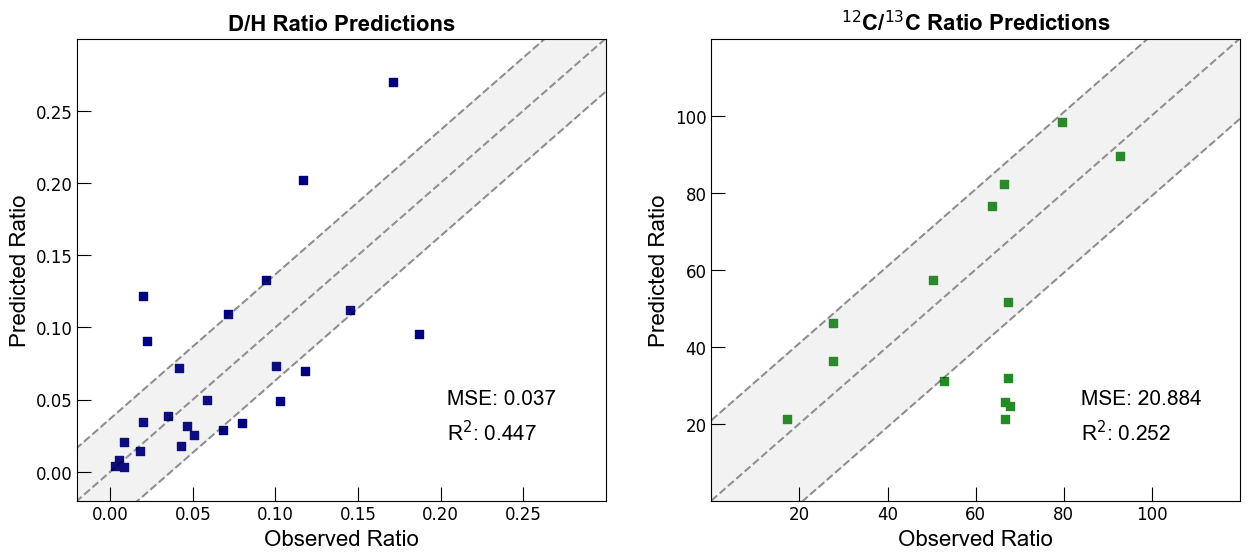

In [23]:
'''
This code cell plots the isotopic ratio predictions of the D and 13C substituted molecules.
The feature vectors contain hand-picked isotope features.
'''


fig, axes =  plt.subplots(1, 2, figsize=(15,6))
axes[0].tick_params(axis='both', which='major', direction = "in", labelsize =12, length = 10, labeltop = False)
axes[1].tick_params(axis='both', which='major', direction = "in", labelsize =12, length = 10, labeltop = False)

ratioMAED = mean_absolute_error(reportRatioD,predictRatioD)
slopeD, interceptD, ratio_r_valueD, p_valueD, std_errD = scipy.stats.linregress(reportRatioD, predictRatioD)
ratioR2D = ratio_r_valueD**2


ratioMAEC = mean_absolute_error(reportRatioC,predictRatioC)
slopeC, interceptC, ratio_r_valueC, p_valueC, std_errC = scipy.stats.linregress(reportRatioC, predictRatioC)
ratioR2C = ratio_r_valueC**2

lineStart2 = -1
lineEnd2 = 1


lineStart2C = 0
lineEnd2C = 1000

print(ratioMAED)
print(ratioMAEC)

xD =  np.arange(lineStart2,lineEnd2,0.001)
xC = np.arange(lineStart2C, lineEnd2C, 0.1)


y1D = xD + ratioMAED
y2D = xD - ratioMAED


y1C = xC + ratioMAEC
y2C = xC - ratioMAEC


axes[0].scatter(reportRatioD, predictRatioD, c='navy', marker= "s")
axes[0].set_title('D/H Ratio Predictions', **hfont, fontsize = 16, fontweight = "bold")
axes[0].plot([lineStart2, lineEnd2], [lineStart2, lineEnd2], ls = "--", alpha = 0.4, color = 'k')
axes[0].plot(xD, y1D, ls = "--", alpha = 0.4, color = 'k')
axes[0].plot(xD, y2D, ls = "--", alpha = 0.4, color = 'k')
axes[0].fill_between(xD, y1D, y2D, color='grey', alpha=0.1)
axes[0].set_xlim([-0.02,0.3])
axes[0].set_ylim([-0.02,0.3])
axes[0].set_xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
axes[0].set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
axes[0].set_ylabel('Predicted Ratio', **hfont, fontsize = 16)
axes[0].set_xlabel('Observed Ratio', **hfont, fontsize = 16)
axes[0].text(0.7, 0.21, f"MSE: {ratioMAED:.3f}", transform=axes[0].transAxes, fontsize = 15, **hfont)
axes[0].text(0.7, 0.13, f"R$^2$: {ratioR2D:.3f}", transform=axes[0].transAxes, fontsize = 15, **hfont)

axes[1].scatter(reportRatioC, predictRatioC, c='forestgreen', marker= "s")
axes[1].set_title('$^{12}$C/$^{13}$C Ratio Predictions', **hfont, fontsize = 16, fontweight = "bold")
axes[1].plot([lineStart2C, lineEnd2C], [lineStart2C, lineEnd2C], ls = "--", alpha = 0.4, color = 'k')
axes[1].plot(xC, y1C, ls = "--", alpha = 0.4, color = 'k')
axes[1].plot(xC, y2C, ls = "--", alpha = 0.4, color = 'k')
axes[1].fill_between(xC, y1C, y2C, color='grey', alpha=0.1)
axes[1].set_ylabel('Predicted Ratio', **hfont, fontsize = 16)
axes[1].set_xlabel('Observed Ratio', **hfont, fontsize = 16)
axes[1].set_xlim([0, 120])
axes[1].set_ylim([0,120])
axes[1].set_xticks([20, 40, 60, 80, 100 ])
axes[1].set_yticks([20, 40, 60, 80, 100 ])
#axes[1].plot(np.arange(14,19), np.arange(14, 19), ls="--", alpha=0.4, color="k")
#axes[1].plot(np.arange(0,80), np.arange(0, 80), ls="--", alpha=0.4, color="k")
axes[1].text(0.7, 0.21, f"MSE: {ratioMAEC:.3f}", transform=axes[1].transAxes, fontsize = 15, **hfont)
axes[1].text(0.7, 0.13, f"R$^2$: {ratioR2C:.3f}", transform=axes[1].transAxes, fontsize = 15, **hfont)
plt.show()



In [24]:
'''
This function splits the deuterated molecules in the dataset into five "folds" of training
and validation sets for 5-fold cross validation. The feature vectors in this case are those 
generated by mol2vec with no additional isotopic encoding.

All deuterated isotopologues of the same molecule are assigned to the validation set of a 
single fold. 

The data for each fold is then appropriately bootstrapped and scaled. 

Returns:

xTrain: List of five lists. Each contains the bootstrapped and scaled feature vectors of the molecules
assigned to the training data on one fold.

yTrain: List of five lists. Each contains the bootstrapped column densities of the molecules
assigned to the training data on one fold.

xTest: List of five lists. Each contains the bootstrapped and scaled feature vectors of the molecules
assigned to the validation data on one fold.

yTest: List of five lists. Each contains the bootstrapped column densities of the molecules
assigned to the validation data on one fold.


finalSmiles: List of five lists. Each contains the SMILES strings of the molecules assigned
to the validation data on one fold

'''


def getSplitsD_mol2vec(n = 5, bootSize = 800):
    fullPath = os.path.join(os.getcwd(), 'dRatiosFinal.csv')
    iso = pd.read_csv(fullPath)
    smiles = list(iso['smiles'])
    parentIdx = list(iso['parent idx'])
    maxIdx = max(parentIdx) + 1 
    
    listIdx = list(range(maxIdx))

    kf = KFold(n_splits=n, shuffle = True, random_state = 0)
    fullTrain = []
    fullTest = []
    for train, test in kf.split(listIdx):
        fullTrain.append(train)
        fullTest.append(test)

    
    testSmiles = []
    
    for sub in fullTest:
        subSmiles = []
        for i in range(len(parentIdx)):
            if parentIdx[i] in sub:
                subSmiles.append(smiles[i])
                    
        testSmiles.append(subSmiles)
    
    
    
    fullPath2 = os.path.join(os.getcwd(), 'deuterium_mol2vec.csv')
    full = pd.read_csv(fullPath2)
    
    fullSmiles = list(full['smiles'])
    vectors = stringToList(list(full['final vectors 70']))
    cd = np.log10(np.asarray(full['N']))
    
    
    xTrain = []
    yTrain = []
    xTest = []
    yTest = []
    
    
    finalSmiles = []
    for sub in testSmiles:
        splitSmiles = []
        sub_x_Train = []
        sub_y_Train = []
        sub_x_Test = []
        sub_y_Test = []
        for i in range(len(fullSmiles)):
            if fullSmiles[i] in sub:
                splitSmiles.append(fullSmiles[i])
                sub_x_Test.append(vectors[i])
                sub_y_Test.append(cd[i])

            else:
                sub_x_Train.append(vectors[i])
                sub_y_Train.append(cd[i])
        sub_x_Train = np.asarray(sub_x_Train)
        sub_y_Train = np.asarray(sub_y_Train)
        sub_x_Test = np.asarray(sub_x_Test)
        sub_y_Test = np.asarray(sub_y_Test)
        X_train_boot, y_train_boot = get_bootstrap_samples((sub_x_Train, sub_y_Train), n_samples = 800)
        X_train_scaled, X_test_scaled= scaleDataVal(X_train_boot,sub_x_Test)
        xTrain.append(X_train_scaled)
        yTrain.append(y_train_boot)
        xTest.append(X_test_scaled)
        yTest.append(sub_y_Test)
        finalSmiles.append(splitSmiles)
            
            
 
    return xTrain, yTrain, xTest, yTest, finalSmiles
   
   

In [25]:
'''
This code cell runs five-fold cross validation on the folds of deuterated data that is split with the 
getSplitsD_mol2vec() function. The prediction and reported column densities are saved to a csv file along with the predicted and reported
isotopic ratios.
'''

GPR_paramSet = (0.1, 10, 10, 0.1, 20, 3)
kernel = WhiteKernel(GPR_paramSet[3], noise_level_bounds = (1e-30, 1e30))+ RationalQuadratic(alpha = GPR_paramSet[1], length_scale = GPR_paramSet[0], length_scale_bounds = (1e-30, 1e30), alpha_bounds = (1e-30, 1e30)) + DotProduct(sigma_0=GPR_paramSet[2], sigma_0_bounds = (1e-30, 1e30)) 
model = GaussianProcessRegressor(kernel = kernel, normalize_y = True, n_restarts_optimizer = GPR_paramSet[4], alpha = GPR_paramSet[5])

fullPredictions = []
xTrain, yTrain, xTest, yTest, smilesList = getSplitsD_mol2vec(n = 5)
for i in range(len(xTrain)):
    X_train = xTrain[i]
    y_train = yTrain[i]
    X_test = xTest[i]
    y_test = yTest[i]
    smiles_test = smilesList[i]
    result = model.fit(X_train, y_train)
    test_pred, test_sd = result.predict(X_test, return_std = True)

    for i in range(len(test_pred)):
        fullPredictions.append((smiles_test[i],test_pred[i], test_sd[i]))

fullPath = os.path.join(os.getcwd(), 'dRatiosFinal.csv')
fullUpload = pd.read_csv(fullPath)


smiles = list(fullUpload['smiles'])
reportCD = list(fullUpload['reported CD'])
parentCD = list(fullUpload['parent CD'])

smilesPred = [i[0] for i in fullPredictions]
cd = [i[1] for i in fullPredictions]
sd = [i[2] for i in fullPredictions]


sdFinal = []
ratio = []
predFinal = []
residualList = []



for i in range(len(smiles)):
    idx = smilesPred.index(smiles[i])
    parentVal = parentCD[i]
    smile = smilesPred[idx]
    cdVal = cd[idx]
    sdVal = sd[idx]

    sdFinal.append(sdVal)
    predFinal.append(cdVal)


    reportVal = reportCD[i]

    residual = abs(cdVal - reportVal)

    residualList.append(residual)

    predValExp = 10**(cdVal)
    parentValExp = 10**(parentVal)

    ratioVal = predValExp/parentValExp

    ratio.append(ratioVal)


fullUpload['predicted ratio'] = ratio
fullUpload['predicted CD'] = predFinal
fullUpload['residual'] = residualList
fullUpload['sd'] = sdFinal

saveString = 'deuterium_mol2vec_results.csv'

savePath = os.path.join(os.getcwd(), saveString)
fullUpload.to_csv(savePath)

<Figure size 640x480 with 0 Axes>

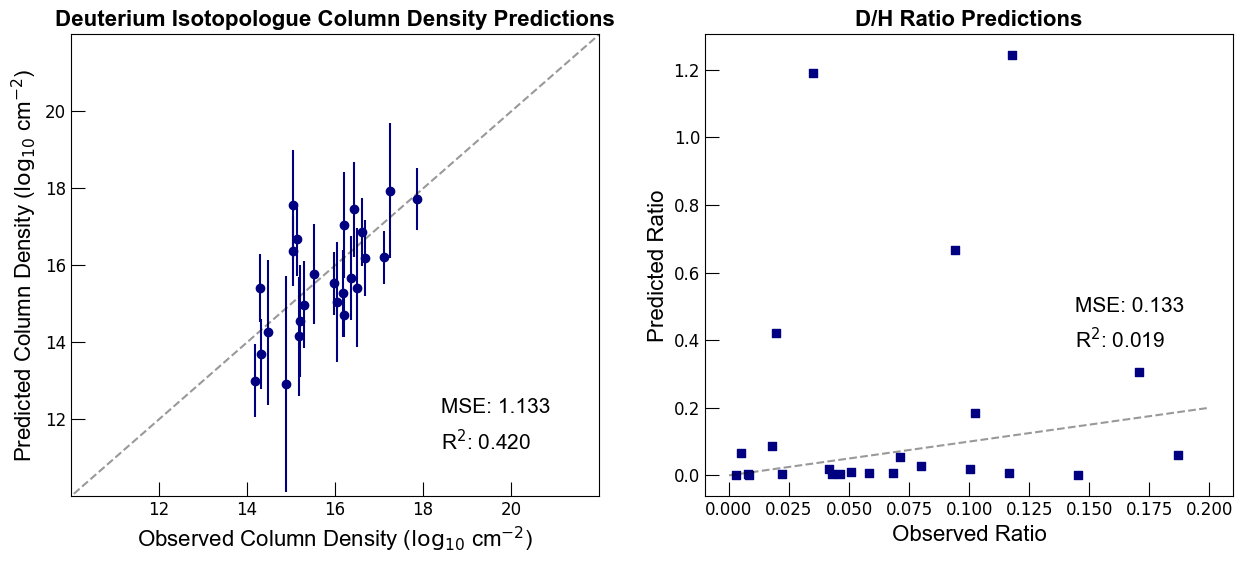

In [26]:
'''
This code cell plots the predicted column density and isotopic ratios for the
deuterated molecules. The feature vectors in this case are those 
generated by mol2vec with no additional isotopic encoding. The Figure is displayed 
in the paper

'''

import scipy
r2List = []

r2List = []
mseList = []


hfont = {'fontname':'Arial'}
pathString = 'deuterium_mol2vec_results.csv'
fullPath = os.path.join(os.getcwd(), pathString)
full = pd.read_csv(fullPath)
reportList = list(full['reported CD'])
predictList = list(full['predicted CD'])
sdList = np.asarray(list(full['sd']))
reportRatio = list(full['reported ratio'])
predictRatio = list(full['predicted ratio'])
plt.figure()
lineStart = 14
lineEnd = 18
detectedMAE = mean_squared_error(reportList,predictList)
detectedR2 = r2_score(reportList,predictList)
mseList.append(detectedMAE)
slope, intercept, cd_r_value, p_value, std_err = scipy.stats.linregress(reportList, predictList)
detectedR2 = cd_r_value**2
lineStart2 = 0
lineEnd2 = 0.2

delList = []
for i in range(len(predictRatio)):
    if predictRatio[i] > 2:
        delList.append(i)

        
delList.sort()
delList.reverse()
for i in delList:
    del predictRatio[i]
    del reportRatio[i]


ratioMAE = mean_squared_error(reportRatio,predictRatio)

slope, intercept, ratio_r_value, p_value, std_err = scipy.stats.linregress(reportRatio, predictRatio)
ratioR2 = ratio_r_value**2
r2List.append(ratioR2)

fig, axes =  plt.subplots(1, 2, figsize=(15,6))
axes[0].tick_params(axis='both', which='major', direction = "in", labelsize =12, length = 10, labeltop = False)
axes[1].tick_params(axis='both', which='major', direction = "in", labelsize =12, length = 10, labeltop = False)

axes[0].errorbar(reportList, predictList, yerr = sdList, fmt="o", c='navy', label='Train')
axes[0].set_title('Deuterium Isotopologue Column Density Predictions', **hfont, fontsize = 16, fontweight = "bold")
axes[0].plot(np.arange(0,100), np.arange(0,100), ls="--", alpha=0.4, color="k")
axes[0].set_ylabel('Predicted Column Density ($\log_{10}$ cm$^{-2}$)', **hfont, fontsize = 16)
axes[0].set_xlabel('Observed Column Density ($\log_{10}$ cm$^{-2}$)', **hfont, fontsize = 16)
axes[0].set_xlim(10,22)
axes[0].set_ylim(10,22)
axes[0].set_xticks([12, 14, 16, 18, 20])
axes[0].set_yticks([12, 14, 16, 18, 20])
axes[0].text(0.7, 0.18, f"MSE: {detectedMAE:.3f}", transform=axes[0].transAxes, fontsize = 15, **hfont)
axes[0].text(0.7, 0.1, f"R$^2$: {detectedR2:.3f}", transform=axes[0].transAxes, fontsize = 15, **hfont)

axes[1].scatter(reportRatio, predictRatio, c='navy', marker= "s")
axes[1].set_title('D/H Ratio Predictions', **hfont, fontsize = 16, fontweight = "bold")
axes[1].plot([lineStart2, lineEnd2], [lineStart2, lineEnd2], ls = "--", alpha = 0.4, color = 'k')
axes[1].set_ylabel('Predicted Ratio', **hfont, fontsize = 16)
axes[1].set_xlabel('Observed Ratio', **hfont, fontsize = 16)
axes[1].text(0.7, 0.40, f"MSE: {ratioMAE:.3f}", transform=axes[1].transAxes, fontsize = 15, **hfont)
axes[1].text(0.7, 0.32, f"R$^2$: {ratioR2:.3f}", transform=axes[1].transAxes, fontsize = 15, **hfont)
plt.show()
